In [1]:
####Dynamic Linear Regression model####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import calendar
import statsmodels
import statsmodels.api as sm
from datetime import datetime
from datetime import timedelta
from scipy import sparse
from scipy.stats import norm
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.array(np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1), dtype="int")
    return z_id
    
#連続した日付を取得する関数
def daterange(_start, _end):
    for n in range((_end - _start).days):
        yield _start + timedelta(n)

In [3]:
####シミュレーションデータを生成####
##日付データを作成
#対象期間の日付と曜日情報を出力
start = datetime.strptime('2014-01-01', '%Y-%m-%d')
end   = datetime.strptime('2019-09-30', '%Y-%m-%d')
get_date = np.array([])
day_of_week = np.array([], dtype="int")
for day in daterange(start, end):
    get_date = np.append(get_date, day)
    day_of_week = np.append(day_of_week, day.weekday())
    
#日付を定義
Timestamp = pd.Series(get_date)
date = pd.DataFrame({"date": Timestamp.astype("U")})
date_df = pd.merge(date, pd.DataFrame({"date": np.unique(date), "date_id": np.arange(date.shape[0])}), on="date", how="inner")
year = pd.DataFrame({"year": Timestamp.astype("U").str[:4]})
unique_year = np.unique(year)
year_df = pd.merge(year, pd.DataFrame({"year": unique_year, "year_id": np.arange(unique_year.shape[0])}), on="year", how="inner")
month = pd.DataFrame({"month": Timestamp.astype("U").str[:7]})
unique_month = np.unique(month)
month_df = pd.merge(month, pd.DataFrame({"month": unique_month, "month_id": np.arange(unique_month.shape[0])}), on="month", how="inner")

#週を定義
freq = pd.Series(day_of_week).value_counts()
argmax_week = freq.index[np.argmax(np.array(freq))]
index = np.array(np.where(day_of_week==0)[0], dtype="int")
if np.min(index)!=0:
    index = np.append(0, index)
if np.max(index)!=day_of_week.shape[0]-1:
    index = np.append(index, day_of_week.shape[0])
weeks = index.shape[0] - 1
week = np.repeat(0, day_of_week.shape[0])
for i in range(weeks):
    if i==0:
        get = np.arange(index[i], index[i+1])
        week[get] = np.repeat(i, get.shape[0])
    else:
        get = np.arange(index[i], index[i+1])
        week[get] = np.repeat(i, get.shape[0])
        
#データフレームを作成
calendar_df = pd.concat((date_df[["date"]], year_df, month_df, pd.DataFrame({"week_id": week, "day_of_week": day_of_week})), axis=1)
calendar_df["month_index"] = calendar_df["month"].str[5:7].astype("int")

In [4]:
##データの生成
#データの定義
days = calendar_df["date"].shape[0]
weeks = np.unique(calendar_df["day_of_week"]).shape[0]
months = np.unique(calendar_df["month_index"]).shape[0]

In [5]:
#周期成分を生成
week = np.array(np.eye(weeks), dtype="int")[np.array(calendar_df["day_of_week"]), 1:]
month = np.array(np.eye(months), dtype="int")[np.array(calendar_df["month_index"])-1, 1:]
Z = np.hstack((np.random.beta(2.5, 5.0, days)[:, np.newaxis], np.random.beta(4.0, 3.0, days)[:, np.newaxis])) 
k = week.shape[1] + month.shape[1] + 1

#週成分の制約インデックスを定義
week_allocation = [i for i in range(days)]
for i in range(days):
    if i <= weeks-1:
        week_allocation[i] = np.sort(np.arange(0, i))[::-1]
    else:
        week_allocation[i] = np.sort(np.arange(days)[i-weeks+1:i])[::-1]

In [6]:
##静的および動的パラメータを生成
#状態パラメータ
s = 5
S1 = np.array([0.05, 0.15, 0.6, 0.15, 0.05])
S2 = np.array([[0.82, 0.11, 0.06, 0.01, 0.01],
               [0.11, 0.79, 0.07, 0.02, 0.01],
               [0.01, 0.02, 0.95, 0.02, 0.01],
               [0.01, 0.02, 0.07, 0.79, 0.11],
               [0.01, 0.01, 0.06, 0.11, 0.82]])

#状態推移を生成
z = np.repeat(0, days)
for i in range(days):
    if i==0:
        z[i] = np.argmax(np.random.multinomial(1, S1, 1))
    else:
        z[i] = np.argmax(np.random.multinomial(1, S2[z[i-1], ], 1))
        
#初期値の設定
tau = np.array([0.005, 0.005, 0.005, 0.0025, 0.0025])
trend = np.append(np.random.normal(0, tau[0], 1), np.repeat(0.0, days-1))
ar = np.append(np.random.normal(0, 0.05, 1), np.repeat(0.0, days-1))
seasonal = np.append(np.random.normal(0, 0.3, weeks), np.repeat(0.0, days-weeks))
theta = np.vstack((np.random.normal(0, 0.2, Z.shape[1]), np.zeros((days-1, Z.shape[1]))))

#時間ごとにパラメータを生成
for i in range(1, days):
    diff_trend = np.sort(np.random.normal(0, tau[0], s))
    trend[i] = trend[i-1] + diff_trend[z[i-1]]
    ar[i] = ar[i-1] + np.random.normal(0, tau[1], 1)
    theta[i, ] = theta[i-1, ] + np.random.multivariate_normal(np.repeat(0.0, Z.shape[1]), np.diag(tau[3:]), 1)
    if i >= weeks-1:
        seasonal[i] = np.sum(-seasonal[week_allocation[i]]) + np.random.normal(0, tau[2], 1)
        
#静的パラメータを生成
Sigma = np.array([0.5])
beta = np.random.normal(0, 0.3, months-1)
Sigmat = Sigma.copy(); betat = beta.copy()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


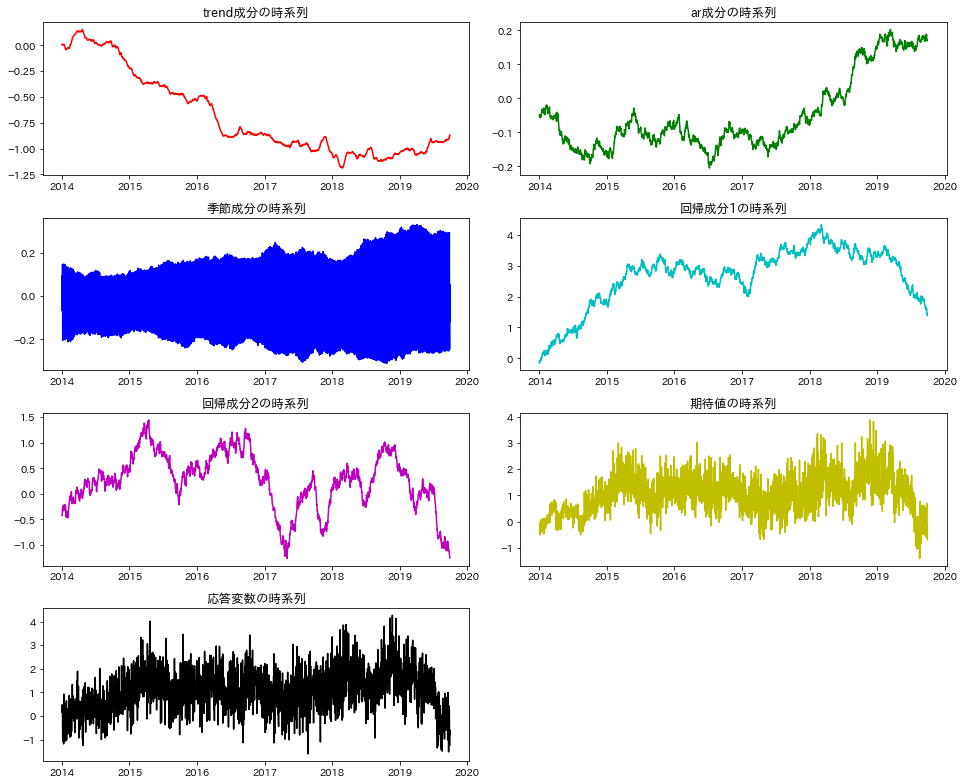

In [7]:
###### 応答変数を生成
#日時での動的変数を生成
y = np.repeat(0.0, days)
mu = np.repeat(0.0, days)
for i in range(days):
    if i==0:
        mu[i] = seasonal[i] + np.dot(Z[i, ], theta[i, ])
    else:
        mu[i] = ar[i]*y[i-1] + seasonal[i] + np.dot(Z[i, ], theta[i, ])
        
    #正規分布から応答変数を生成
    mu[i] += np.dot(month[i, ], beta)
    y[i] = mu[i] + np.random.normal(0, Sigma, 1)
    
#データフレームを作成
datetime = np.array(date, dtype="datetime64[D]").reshape(-1)
df = pd.DataFrame({"日付": datetime, "応答変数": y, "期待値": mu, "trend成分": trend, "ar成分": ar, "季節成分": seasonal,
                   "回帰成分1": theta[:, 0], "回帰成分2": theta[:, 1]})
df.index = np.array(date, dtype="datetime64[D]").reshape(-1)

#生成したパラメータとデータの可視化
dt = [df["trend成分"], df["ar成分"], df["季節成分"], df["回帰成分1"], df["回帰成分2"], df["期待値"], df["応答変数"]]
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["trend成分の時系列", "ar成分の時系列", "季節成分の時系列", "回帰成分1の時系列", "回帰成分2の時系列", 
          "期待値の時系列", "応答変数の時系列"]
fig = plt.figure(figsize=(13.5, 11.0))
for j in range(len(dt)):
    ax = fig.add_subplot(4, 2, j+1)
    ax.plot(dt[j], color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [120]:
####カルマンフィルターで動的回帰モデルを推定####
##カルマンフィルタを計算する関数
#カルマンフィルタを逐次計算する関数
def KF(beta, tau, Sigma, y, D, H, x, V, Q, F, G, days):
    
    #モデル誤差を定義
    er = y - np.dot(D, beta)
    Fxs = np.zeros((days, x.shape[0]))
    params = np.zeros((days, x.shape[0]))
    VF_list = [i for i in range(days)]
    V_list = [i for i in range(days)]
    
    for i in range(days):
        #1期先予測
        Fx = np.dot(F, x)
        VF = np.dot(np.dot(F, V), F.T) + np.dot(np.dot(G, tau*Q), G.T)

        #フィルタリング
        index = np.array([i])
        HVH = np.dot(np.dot(H[index, ], VF), H[index, ].T) + np.power(Sigma, 2)
        inv_HVH = np.linalg.inv(HVH)
        K = np.dot(np.dot(VF, H[index, ].T), inv_HVH)   #カルマンゲイン
        new_x = Fx + np.dot(K, er[i] - np.dot(H[i, ], Fx)).reshape(-1)
        new_V = VF - np.dot(np.dot(K, H[index, ]), VF)

        #パラメータの更新
        x = new_x.copy()
        V = new_V.copy()
        Fxs[i, ] = Fx
        params[i, ] = new_x
        VF_list[i] = VF
        V_list[i] = new_V
    return Fxs, params, VF_list, V_list

#カルマンフィルタの対数尤度
def loglike(beta, tau, Sigma, y, D, H, x, V, Q, F, G, days):
    
    #モデル誤差を定義
    er = y - np.dot(D, beta)
    params = np.zeros((days, x.shape[0]))
    Kal = np.repeat(0.0, days)

    for i in range(days):
        #1期先予測
        Fx = np.dot(F, x)
        VF = np.dot(np.dot(F, V), F.T) + np.dot(np.dot(G, tau*Q), G.T)

        #フィルタリング
        index = np.array([i])
        HVH = np.dot(np.dot(H[index, ], VF), H[index, ].T) + np.power(Sigma, 2)
        inv_HVH = np.linalg.inv(HVH)
        K = np.dot(np.dot(VF, H[index, ].T), inv_HVH)   #カルマンゲイン
        new_x = Fx + np.dot(K, er[i] - np.dot(H[i, ], Fx)).reshape(-1)
        new_V = VF - np.dot(np.dot(K, H[index, ]), VF)

        #パラメータの更新
        x = new_x.copy()
        V = new_V.copy()
        params[i, ] = x
        mu = np.dot(H[i, ], Fx) + np.dot(D[i, ], beta)
        Kal[i] = np.log(np.linalg.det(HVH)) + np.dot(np.dot(y[i]-mu, inv_HVH), y[i]-mu)

    #対数尤度の和
    Lho = -1/2 * (days*np.log(2*np.pi) + np.sum(Kal))
    return -Lho

In [80]:
##静的パラメータの初期値を設定
#3次回期のパラメータを推定
c = np.array(np.arange(days)/days)[:, np.newaxis]
C = np.hstack((np.repeat(1.0, days)[:, np.newaxis], c, np.power(c, 2), np.power(c, 3), 
               np.append(0, y[:days-1])[:, np.newaxis], Z, week, month))
xy = np.dot(C.T, y)
inv_xx = np.linalg.inv(np.dot(C.T, C))
alpha = np.dot(inv_xx, xy)

#静的パラメータを定義
par = 5
D = month.copy()
beta = alpha[(C.shape[1]-(months-1)):]
Sigma = np.sqrt(np.sum(np.power(y - np.dot(C, alpha), 2)) / days)
tau = np.array([0.01, 0.0025, 0.005, 0.005, 0.005])

In [91]:
##準ニュートン法で静的パラメータを推定
#動的パラメータの初期値
trend = y[0]
ar = 0.0
seasonal = np.append(0.2, np.repeat(0.0, weeks-2))
theta = np.random.normal(0, 0.1, Z.shape[1])

#システムモデルの定義
index_week = np.arange(3, 3+weeks-1)
x = np.hstack((trend, ar, seasonal, theta))

In [92]:
##準ニュートン法で静的パラメータを推定
#動的パラメータの初期値
trend = y[0]
ar = 0.0
seasonal = np.append(0.2, np.repeat(0.0, weeks-2))
theta = np.random.normal(0, 0.1, Z.shape[1])

#システムモデルの定義
index_week = np.arange(3, 3+weeks-1)
x = np.hstack((trend, ar, seasonal, theta))
f = tau.shape[0]-1 + weeks - 1
F = np.zeros((f, f))
F[0, 0] = np.array([1.0])
F[1, 1] = np.array([1.0])
F[2:2+weeks-1, 2:2+weeks-1] = np.vstack((np.repeat(-1, weeks-1), np.diag(np.repeat(1.0, weeks-1))[:weeks-2]))
F[f-2:, f-2:] = np.diag(np.repeat(1.0, Z.shape[1]))
G = np.zeros((f, par))
G[0, 0] = np.array([1.0])
G[1, 1] = np.array([1.0])
G[2, 2] = np.array([1.0])
G[f-2:, 3:] = np.diag(np.repeat(1.0, Z.shape[1]))
V = np.diag(np.repeat(100.0, f))
Q = np.diag(np.repeat(1.0, par))
H = np.hstack((np.repeat(1.0, days)[:, np.newaxis], np.append(0.0, y[0:days-1])[:, np.newaxis], 
               np.repeat(1.0, days)[:, np.newaxis], np.zeros((days, weeks-2)), Z))

#対数尤度を最大化
beta = alpha[(C.shape[1]-(months-1)):]
res = optimize.minimize(loglike, beta, method="BFGS", args=(tau, Sigma, y, D, H, x, V, Q, F, G, days), options={"disp": True})
beta = res.x

#モデル誤差のパラメータを更新
new_x = KF(beta, tau, Sigma, y, D, H, x, V, Q, F, G, days)[1]
mu = np.sum(H * new_x, axis=1) + np.dot(D, beta)
Sigma = np.sqrt(np.sum(np.power(y - mu, 2)) / days)

         Current function value: 2150.253983
         Iterations: 18
         Function evaluations: 352
         Gradient evaluations: 27


In [194]:
##固定区間平滑化でパラメータを平滑化
#動的パラメータの初期値
par = 5   #システムモデルのパラメータ数
x = np.hstack((trend, ar, seasonal, theta))
tau = np.array([0.01, 0.0025, 0.005, 0.005, 0.005])
new_x = KF(beta, tau, Sigma, y, D, H, x, V, Q, F, G, days)[0]

#システムモデルの定義
index_week = np.arange(3, 3+weeks-1)
x = new_x[0, ]
f = tau.shape[0]-1 + weeks - 1
F = np.zeros((f, f))
F[0, 0] = np.array([1.0])
F[1, 1] = np.array([1.0])
F[2:2+weeks-1, 2:2+weeks-1] = np.vstack((np.repeat(-1, weeks-1), np.diag(np.repeat(1.0, weeks-1))[:weeks-2]))
F[f-2:, f-2:] = np.diag(np.repeat(1.0, Z.shape[1]))
G = np.zeros((f, par))
G[0, 0] = np.array([1.0])
G[1, 1] = np.array([1.0])
G[2, 2] = np.array([1.0])
G[f-2:, 3:] = np.diag(np.repeat(1.0, Z.shape[1]))
V = np.diag(np.repeat(100.0, f))
Q = np.diag(np.repeat(1.0, par))
H = np.hstack((np.repeat(1.0, days)[:, np.newaxis], np.append(0.0, y[0:days-1])[:, np.newaxis], 
               np.repeat(1.0, days)[:, np.newaxis], np.zeros((days, weeks-2)), Z))

#1期先予測とフィルタリングで動的パラメータを更新
res = KF(beta, tau, Sigma, y, D, H, x, V, Q, F, G, days)
Fx = res[0]
x = res[1]
VF_list = res[2]
V_list = res[3]

#初期値を定義
new_x = np.vstack((np.zeros((days-1, x.shape[1])), x[days-1, ]))
new_V = [i for i in range(days)]
new_V[days-1] = V_list[days-1]

#固定区間平滑化でパラメータを更新
for i in np.arange(days-1)[::-1]:
    A = np.dot(np.dot(V_list[i], F.T), np.linalg.inv(VF_list[i+1]))
    new_x[i, ] = x[i, ] + np.dot(A, new_x[i+1, ] - Fx[i+1, ])
    new_V[i] = V_list[i] + np.dot(np.dot(A, new_V[i+1] - VF_list[i+1]), A.T)

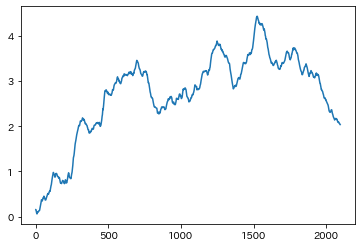

In [208]:
j = 8
plt.plot(new_x[:, j])

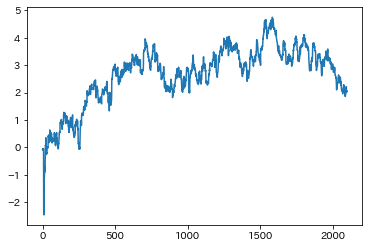

In [209]:
plt.plot(x[:, j])

In [111]:
def KF(beta, tau, Sigma, y, D, H, x, V, Q, F, G, days):
    
    #モデル誤差を定義
    er = y - np.dot(D, beta)
    Fxs = np.zeros((days, x.shape[0]))
    params = np.zeros((days, x.shape[0]))
    VF_list = [i for i in range(days)]
    V_list = [i for i in range(days)]
    
    for i in range(days):
        #1期先予測
        Fx = np.dot(F, x)
        VF = np.dot(np.dot(F, V), F.T) + np.dot(np.dot(G, tau*Q), G.T)

        #フィルタリング
        index = np.array([i])
        HVH = np.dot(np.dot(H[index, ], VF), H[index, ].T) + np.power(Sigma, 2)
        inv_HVH = np.linalg.inv(HVH)
        K = np.dot(np.dot(VF, H[index, ].T), inv_HVH)   #カルマンゲイン
        new_x = Fx + np.dot(K, er[i] - np.dot(H[i, ], Fx)).reshape(-1)
        new_V = VF - np.dot(np.dot(K, H[index, ]), VF)

        #パラメータの更新
        x = new_x.copy()
        V = new_V.copy()
        Fxs[i, ] = Fx
        params[i, ] = new_x
        VF_list[i] = VF
        V_list[i] = new_V
    return Fxs, params, VF_list, V_list

[array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]]),
 array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan,

In [89]:
#初期値を定義
new_trend = np.append(np.repeat(0.0, days-1), trend[days-1])
new_V = [i for i in range(days)]
new_V[days-1] = VF_list[days-1]

#固定区間平滑化でパラメータを更新
for i in np.arange(days-1)[::-1]:
    A = np.dot(np.dot(V_list[i], F), np.linalg.inv(VF_list[i]))
    new_trend[i] = trend[i] + np.dot(A, new_trend[i+1] - np.dot(F, trend[i]))
    new_V[i] = V_list[i] + np.dot(np.dot(A, new_V[i+1] - V_list[i]), A.T)

array([[ 0.19645961,  0.        , -0.02904696, ..., -0.02835345,
        -0.02052478,  0.02061189],
       [ 0.29556345,  0.01847069,  0.09231822, ..., -0.01756485,
        -0.00549254,  0.10365769],
       [ 0.29697124,  0.01983849, -0.01383836, ..., -0.01743368,
        -0.00432147,  0.10371776],
       ...,
       [-0.71728831, -0.0152956 , -0.03839753, ..., -0.40212775,
         2.0649601 , -1.15361708],
       [-0.81096533,  0.01127646,  0.00928306, ...,  0.2818937 ,
         2.09287634, -1.10376876],
       [-0.83009333,  0.03522254, -0.4526957 , ..., -0.27728974,
         2.05634892, -1.20775626]])